# Implementation of the stereoscopic cone reconstruction algorithm by De MA

 [1] Song De Ma, Conic-Based Stereo, Motion Estimation, and Pose Determination, Int. Journal of Computer Vision, 1993
 
 
 ## Coordinate System
 
 ![Relation between coordinate systems](Coordinate_system.png)
 
 
 ## Fundamental Relations 
 - Assumption 1 - focal lenght of camera $f=1$
 - Assumption 2 - Points of pupil ellipse lie on the image plane and can be described through homogenous coordinate $[u_i, v_i, 1]$
 - Assumption 3 - Points on the pupil ellipse lie in word coordinates $C_w$ within the x-y plane and thus can be described by $[x_w, y_w, 0]$
 
 ### Relation World to image coordinates
$$u_i = f * x_w/z_w, v_i = f * y_w/z_w$$
 
 ### Geometric constraints
 Transformation between points in world and camera coordinate system
 $ x_i = R_i x_w + ti $ for $i=1,2 $
 
 which can be rewritten as homogeneous transformation of points in the object plane to the camera coordinate system
 
 $ x_i = G_i u_w  with u_w = [x_w, y_w, 1]$ with $G_i = [r_{i1}, r_{i2}, t_i]$  where $r_{i1}$ and $r_{i1}$ are the first two columns of $R_i$
 
 Further $u_w^T Q u_w = 0$ describes the conic $Q$ in world coordinates and $u_i^T A_i u_i = 0$ gives the ellipse projection of $Q$ within the ith camera. 
 
 Thus we can write 
 $u_w^T G_i^T A_i G_i u_w = 0$ and $G_i^T A_i G_i = k_i Q$ where $k_i$ is an unknown scaling factor. 
 
 ### Input to Algorithm 
 
 1. Known intrinsics of both camera sensors as camera matrix $K_i$
 2. Ridgid transformation between both camera sensors $R,t$
 3. Fitted ellipses within both camera frames $E_i$ given as general ellipse described by $(x0,y0, a ,b, \phi)$
 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import scipy as sci
from helper_functions import fit_ellipse, transform_ellipse, construct_ellipse, calc_A, calc_R_t_stereo, projectPoint


In [11]:
foc = 1.0 # focal length set to 1 
K1 = np.asmatrix(np.array([[foc,0,0.0],[0,foc,0.0],[0,0,1.0]]))
K2 = np.asmatrix(np.array([[foc,0,0.0],[0,foc,0.0],[0,0,1.0]]))
pupil_radius = 2 # 2mm

camera_center_left = np.array([10, -20, 50])
camera_center_right = np.array([-10, -20, 50])
camera_direction_left = np.array([0, 0, 1]) # central ray of both cameras observing the same spot 
camera_direction_right = np.array([0, 0, 1])

R12, R21, t12, t21, R1, t1, R2, t2 = calc_R_t_stereo(camera_center_left, camera_direction_left, camera_center_right, camera_direction_right)

t1_org = t1
t2_org = t2

R1_org = R1
R2_org = R2

# Generate ellipse data in World coordinate system $C_w$ 
Data points lie on pupil plane thus $z_w = 0$

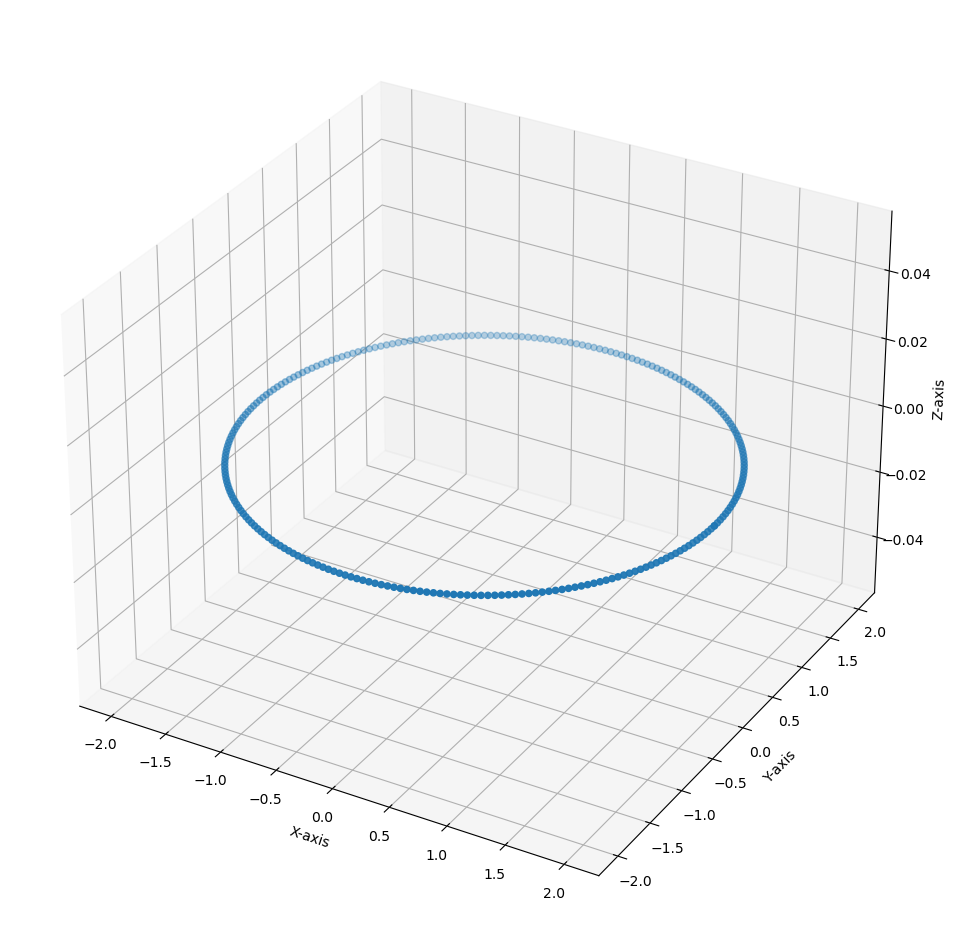

In [12]:
x = []
y = []
Nsamples = 250
for phi in (np.linspace(0, 2 * np.pi, Nsamples)):
    x.append(pupil_radius * np.cos(phi))
    y.append(1*pupil_radius * np.sin(phi))

Cx = np.array(x)
Cy = np.array(y)
Cz = np.zeros_like(Cx)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(Cx, Cy, Cz)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

# Project points from world coordinates $C_w$ to camera coordinate systems $U_w$ 

In [19]:
# Project 3D coords to 2D
# image coordinates and scaling factor
u1c = np.zeros_like(Cx)
v1c = np.zeros_like(Cy)
u1v = np.ones((3, len(u1c)))

u2c = np.zeros_like(Cx)
v2c = np.zeros_like(Cy)
u2v = np.ones((3, len(u2c)))

for i in range(len(u1c)):
    im_point, __ = projectPoint(np.array([Cx[i], Cy[i], 0]), R1,t1,K1)
    im_point = np.squeeze(im_point)
    u1c[i] = im_point[0,0]
    v1c[i] = im_point[0,1]
    u1v[0:2,i] = im_point

    im_point, __ = projectPoint(np.array([Cx[i], Cy[i], 0]), R2,t2,K1)
    im_point = np.squeeze(im_point)
    u2c[i] = im_point[0,0]
    v2c[i] = im_point[0,1]
    u2v[0:2,i] = im_point

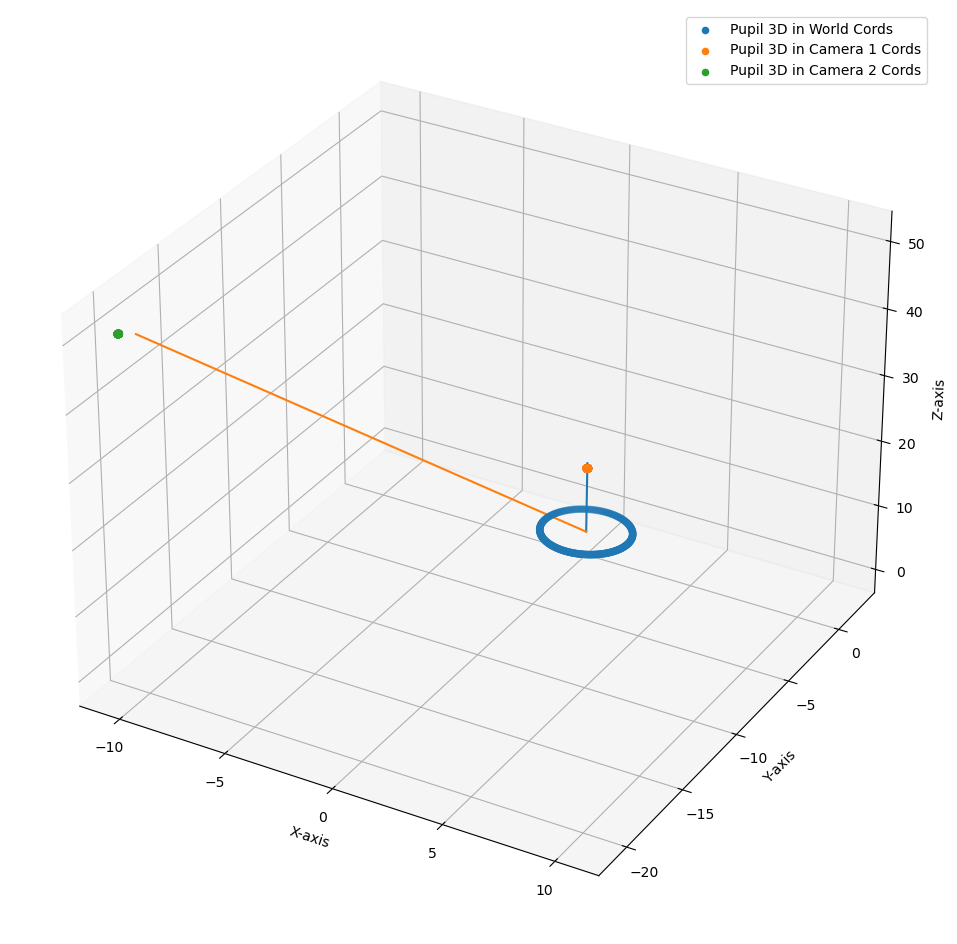

In [14]:
U1 = np.dot(R1,u1v) 
U1 = U1.T + t1
U2 = np.dot(R2,u2v) 
U2 = U2.T + t2

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(Cx, Cy, Cz, label = 'Pupil 3D in World Cords')
ax.scatter(U1[:,0],U1[:,1], U1[:,2], label = 'Pupil 3D in Camera 1 Cords')
ax.scatter(U2[:,0],U2[:,1], U2[:,2], label = 'Pupil 3D in Camera 2 Cords')
ax.plot([camera_center_left[0],0],[camera_center_left[1],0],[camera_center_left[2],0])
ax.plot([camera_center_right[0],0],[camera_center_right[1],0],[camera_center_right[2],0])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.legend()
plt.show()

## Fit ellipses from data points in image coordinate system and calculate A1, A2

In [15]:
# calculate ellipses A1 and A2
ellipse1 = fit_ellipse(u1c, v1c)
ellipse2 = fit_ellipse(u2c, v2c)
E1 = transform_ellipse(ellipse1)
E2 = transform_ellipse(ellipse2)
A1 = construct_ellipse(E1, K1)
A2 = construct_ellipse(E2, K1)
A1 = np.asmatrix(A1)
A2 = np.asmatrix(A2)

#construct G1 and G2 according to De Ma (4)
G1 = np.array([[R1[:,0]],[R1[:,1]],[t1]])
G1 = np.asmatrix(G1.T)

G2 = np.array([[R2[:,0]],[R2[:,1]],[t2]])
G2 = np.asmatrix(G2.T)

#construct Q see De Ma (14), (15) 
Q = np.array([[1/(pupil_radius**2), 0, 0],[0, 1/(pupil_radius**2), 0],[0, 0, -1]])

## Validate implementation of Coordinate transform and construction of A1, A2, G1, G2

In [16]:
# De Ma (7)
u1vec = np.asmatrix(u1v[: , 0])
u2vec = np.asmatrix(u2v[: , 0])

res = u1vec @ A1 @ u1vec.T  # should be 0 
res = u2vec @ A2 @ u2vec.T  # should be 0 

uw  = np.array([Cx[0], Cy[0], 1]) # homogenous world coordinate
# De Ma (8)
res = uw.T @ G1.T @ A1 @ G1 @ uw  # should be 0 
res = uw.T @ G2.T @ A2 @ G2 @ uw  # should be 0 

# Solve (9) for k1 and k2
submat1 = G1.T @ A1 @ G1
submat2 = G2.T @ A2 @ G2

k1 = submat1[2,2]/Q[2,2]
k2 = submat2[2,2]/Q[2,2]

k = k1/k2

k1_red = -t1.T @ A1 @ t1
k2_red = -t2.T @ A2 @ t2

res = k1_red - k1 # should be 0
res = k2_red - k2 # should be 0


# Solve (10) and (11) for a, b (Pupil diameter)!
r11 = R1[:,0]
r12 = R1[:,1]
r21 = R2[:,0]
r22 = R2[:,1]

a1 = float(np.sqrt(k1 / (r11.T @ A1 @ r11)))  # should be 2 mm
b1 = float(np.sqrt(k1 / (r12.T @ A1 @ r12)))  # should be 2 mm
print('a1',a1)
print('b1',b1)

a2 = float(np.sqrt(k2 / (r21.T @ A2 @ r21)))  # should be 2 mm
b2 = float(np.sqrt(k2 / (r22.T @ A2 @ r22)))  # should be 2 mm



u1vec = np.asmatrix(u1v[: , 0])

res = u1vec @ A1 @ u1vec.T 


[[1.44442898e-15]]
[[2.74532653e-15]]
[[3.55816158e-12]]
[[6.96474909e-12]]
[[0.]]
[[0.]]
a1 1.9999999995407536
b1 2.00000000045613


## Conic reconstruction
For reconstruction we assume that the ridgid transform $R,t$ as well as the ellipses in the corresponding image plane $A1,A2$ are known. The goal is now to find the corresponding transformations $R1,R2,t1,t2$ as well as the pupil diameter $a,b$.  

In [20]:
R = np.asmatrix(R12)
t = np.asmatrix(t12)
# 1. Calculate k
k = np.linalg.inv(R.T @ A2 @ R) @ A1
k_mat = np.linalg.inv(R.T @ A2 @ R)
k_mat = k_mat @ A1
k, v = np.linalg.eig(k_mat)

# calculate C  (21) , (22)
C = []
for i in range(3):
    C.append(A1 - k[i] * (R.T @ A2 @ R))

allDets = np.array([np.linalg.det(C[0]), np.linalg.det(C[1]), np.linalg.det(C[2])])
k_idx = np.argmin(np.abs(allDets))
k = np.real(k[k_idx])  # det(C) == 0 (21) needs to be statisfied! --> real ensures non complex solutions if eigenvales become complex 
C = np.real(C[k_idx])

#calculate r13 using (24) --> 4 pot. equivalent solutions see Fig. 2

lamb, lamb_vec = np.linalg.eig(C)
idx = np.argmin(np.abs(lamb))
lamb = np.delete(lamb, idx)
lamb_vec = np.delete(lamb_vec, idx, axis=1)

lamb1 = lamb[0]
s1 = lamb_vec[:,0]
lamb2 = lamb[1]
s2 = lamb_vec[:,1]

r13_1 = np.sqrt(np.abs(lamb1)) * s1 + np.sqrt(np.abs(lamb2)) * s2
r13_1 = np.asmatrix(r13_1/np.linalg.norm(r13_1,2))

r13_2 = np.sqrt(np.abs(lamb1)) * s1 - np.sqrt(np.abs(lamb2)) * s2
r13_2 = np.asmatrix(r13_2/np.linalg.norm(r13_2,2))

r13_3 = -np.sqrt(np.abs(lamb1)) * s1 + np.sqrt(np.abs(lamb2)) * s2
r13_3 = np.asmatrix(r13_3/np.linalg.norm(r13_3,2))

r13_4 = -np.sqrt(np.abs(lamb1)) * s1 - np.sqrt(np.abs(lamb2)) * s2
r13_4 = np.asmatrix(r13_4/np.linalg.norm(r13_4,2))

Err = 1E6

for r13 in (r13_1, r13_2, r13_3, r13_4):
    
        #compute H matrix 
        H = A1 - (r13 @ r13.T) @ A1
        
        # find 2 non 0 elements which belong to r11 and r12
        r, w = np.linalg.eig(H)
        r = np.abs(r)
        idx = np.argmin(r)
        r = np.delete(r, idx)
        w = np.delete(w, idx, axis=1)
        R1_r=np.zeros((3,3))
        R1_r[:,0:2] = w
        R1_r[:,2] = np.asmatrix(r13.T)

        r11 = np.asmatrix(R1_r)[:, 0]
        r12 = np.asmatrix(R1_r)[:, 1]
        r13 = np.asmatrix(R1_r)[:, 2]

        R2_r = R @ R1_r

        r21 = np.asmatrix(R2_r)[:, 0]
        r22 = np.asmatrix(R2_r)[:, 1]
        r23 = np.asmatrix(R2_r)[:, 2]
        
        # calc t1 and t2 relation of t1 and t2 is given by (13)
        t1_1 = r11.T @ A1.T
        t1_2 = r12.T @ A1.T
        t1_3 = r21.T @ A2.T @ R
        t_2_3 = float(-r21.T @ A2.T @ t.T)
        t_loc = np.squeeze([t1_1, t1_2, t1_3])
        t2_loc = np.asmatrix([0, 0, t_2_3]).T
        t1 = np.linalg.inv(t_loc)
        t1 = t1 @ t2_loc
        t2 = R @ t1 + t.T
        k1 = -t1.T @ A1 @ t1
        k2 = k * k1

        a = float(np.sqrt(k1 / (r11.T @ A1 @ r11)))
        b = float(np.sqrt(k1 / (r12.T @ A1 @ r12)))


        G1 = np.asmatrix(np.squeeze([r11.T, r12.T, t1.T]))
        G1 = G1.T
        G2 = np.asmatrix(np.squeeze([r21.T, r22.T, t2.T]))
        G2 = G2.T
        Q = np.asmatrix([[1 / a ** 2, 0, 0], [0, 1 / b ** 2, 0], [0, 0, -1]])

        # De Ma (25) Projection Error
        E = float(np.linalg.norm(G1.T @ A1 @ G1 - float(k1) * Q,1) + np.linalg.norm(G2.T @ A2 @ G2 - float(k2) * Q,1))

        if np.abs(E) < np.abs(Err):
 
            Err = np.copy(E)
            finale_t1 = np.copy(t1)
            finale_t2  = np.copy(t2)
            finale_a = np.copy(a) 
            finale_b = np.copy(b) 
            finale_R1 = np.copy(R1)
            finale_R2 = np.copy(R2)

            
print('d Error t1 in mm', np.linalg.norm(np.squeeze(t1_org) - finale_t1.T))
print('d Error t2 in mm', np.linalg.norm(np.squeeze(t2_org) - finale_t2.T))

print('a Error in mm', np.linalg.norm(finale_a - pupil_radius))
print('b Error in mm', np.linalg.norm(finale_b - 1*pupil_radius))

print('Rotation Error R1 in a.u.', np.linalg.norm(np.squeeze(R1_org) - finale_R1))
print('Rotation Error R2 in a.u.', np.linalg.norm(np.squeeze(R2_org) - finale_R2))

            
  

d Error t1 in mm 4.274817647423052e-08
d Error t2 in mm 4.274817698958756e-08
a Error in mm 1.040367125781927e-09
b Error in mm 3.8674539126759555e-09
Rotation Error R1 in a.u. 0.0
Rotation Error R2 in a.u. 0.0


C:\Users\Johannes\AppData\Local\Temp\ipykernel_14032\980216957.py:83: RuntimeWarning: invalid value encountered in sqrt
  a = float(np.sqrt(k1 / (r11.T @ A1 @ r11)))


# Calculate gaze angles w.r.t camera 1 and camera 2

In [23]:
x0, y0 = E1[0], E1[1] # center coordinate of conic in image plane of cam1
x1, y1 = E2[0], E2[1] # center coordinate of conic in image plane of cam1

center_dir_vec_c1 = np.asmatrix(np.array([x0,y0,1])) # assuming f = 1 
normal_vec_pupil_c1 = np.linalg.inv(finale_R1) @ (np.linalg.inv(K1) @ center_dir_vec_c1.T - finale_t1) # if f !=1 replace f=1 with f  
normal_vec_pupil_c1 = normal_vec_pupil_c1 / np.linalg.norm(normal_vec_pupil_c1) # normalization of length 1 

center_dir_vec_c2 = np.asmatrix(np.array([x1,y1,1])) # assuming f = 1 
normal_vec_pupil_c2 = np.linalg.inv(finale_R2) @ (np.linalg.inv(K1) @ center_dir_vec_c2.T - finale_t2) # if f !=1 replace f=1 with f  
normal_vec_pupil_c2 = normal_vec_pupil_c2 / np.linalg.norm(normal_vec_pupil_c2) # normalization of length 1 


theta_c1 = np.arctan2(np.sqrt(normal_vec_pupil_c1[0]**2 + normal_vec_pupil_c1[1]**2),normal_vec_pupil_c1[2])
phi_c1 = np.arctan2(normal_vec_pupil_c1[1],normal_vec_pupil_c1[0])

theta_c2 = np.arctan2(np.sqrt(normal_vec_pupil_c2[0]**2 + normal_vec_pupil_c2[1]**2),normal_vec_pupil_c2[2])
phi_c2 = np.arctan2(normal_vec_pupil_c2[1],normal_vec_pupil_c2[0])

print('theta w.r.t. cam1',np.rad2deg(theta_c1))
print('phi w.r.t. cam1',np.rad2deg(phi_c1))

print('theta w.r.t. cam2',np.rad2deg(theta_c2))
print('phi w.r.t. cam2',np.rad2deg(phi_c2))


theta w.r.t. cam1 [[179.78397465]]
phi w.r.t. cam1 [[-63.43494631]]
theta w.r.t. cam2 [[179.78397464]]
phi w.r.t. cam2 [[-116.56505887]]
